# Analysis of AR Tracks in CONUS
### Get masks of ARs, HRRR, and SCREAM data
### Apply Masks to Data
### Create histogram of variables within the mask
#### Filters to apply
1. Land versus ocean
2. CONUS versus global

Lexie Goldberger
05/12/25

Help from:
- Bryce Harrop, PNNL, provided AR Tracks
- Ziming Chen, PNNL, provided SCREAM data
- https://easy.gems.dkrz.de/Processing/healpix/lonlat_remap.html
- https://mesowest.utah.edu/html/hrrr/

Files needed:
- AR tracks for scream /pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/scream2D_ne120_hp8_fast.ar_filtered_nodes.for_Lexie.nc

- times when scream ARs present over CONUS /pscratch/sd/l/lexberg/hackathon2025/my_fork/hk25-teams/hk25-Tracking/selected_times_ARs_over_CONUS.nc

- SCREAM data /pscratch/sd/w/wcmca1/scream-cess-healpix/data4TE

- HRRR data in zarr format on healpix grid /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp*_v*.zarr, * = zoom level, grab latest version

- AR tracks for era5 in zarr format on healpix grid /pscratch/sd/l/lexberg/hackathon2025/ARtracks_ERA5_hpZARR_data/_all_hp*_v*.zarr, * = zoom level, grab latest version

In [91]:
import s3fs
import math
import xarray as xr
import pandas as pd
import numpy as np
import os
import re
import pyproj
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import metpy
import datetime
import cartopy.crs as ccrs
from functools import partial
import healpy
import zarr
import xesmf as xe
import numcodecs
import gc
import warnings
warnings.filterwarnings('ignore')

In [92]:
!groups

lexberg m1867 cmip6 trn006


In [93]:
pwd

'/pscratch/sd/l/lexberg/hackathon2025/my_fork/hk25-teams/hk25-Tracking'

# Functions

In [94]:
def get_zoom_level(ds):
    number = ds.crs.healpix_nside
    return int(math.log2(number))

def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        healpy.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

# 1) Read in Data

### 1.1) AR Tracks Data for Scream Data

/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/scream2D_ne120_hp8_fast.ar_filtered_nodes.for_Lexie.nc
AR_binary_tag: ('time', 'cell'), shape=(240, 786432)


Text(0.5, 1.0, 'AR Masks for Scream Data at 2019-08-13 12:00:00')

<Figure size 640x480 with 0 Axes>

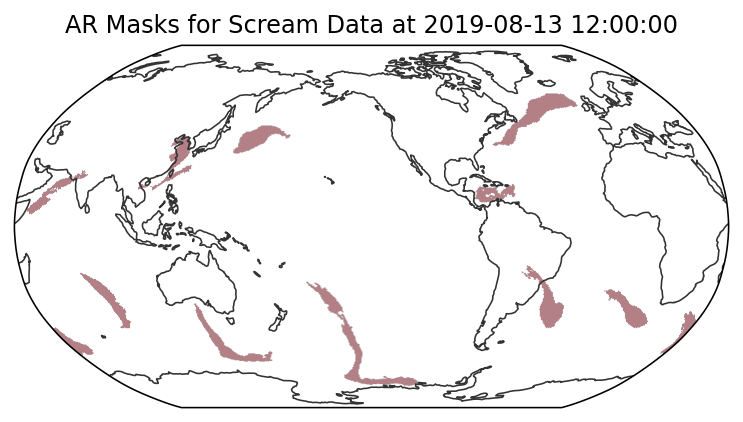

In [218]:
# Get file location
root_dir = '/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/'
in_mask_dir = f'{root_dir}scream2D_ne120_hp8_fast.ar_filtered_nodes.for_Lexie.nc'
print(in_mask_dir)

# Open file
ds_scream_ARtrack = xr.open_dataset(in_mask_dir)

for var in ds_scream_ARtrack.data_vars:
    print(f"{var}: {ds_scream_ARtrack[var].dims}, shape={ds_scream_ARtrack[var].shape}")

# Plot Sample
temp = ds_scream_ARtrack['AR_binary_tag'].isel(time=0).squeeze()
egh.healpix_show(temp.where(temp>0), cmap='Reds_r', dpi=144, alpha=0.5)
plt.title(f"AR Masks for Scream Data at {ds_scream_ARtrack.time.isel(time=0).item()}")

/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/scream2D_ne120_hp8_fast.ar_counts.for_Lexie.nc
AR_count_index: ('time', 'cell'), shape=(240, 786432)


Text(0.5, 1.0, 'AR Masks for Scream Data at 2019-08-13 12:00:00')

<Figure size 640x480 with 0 Axes>

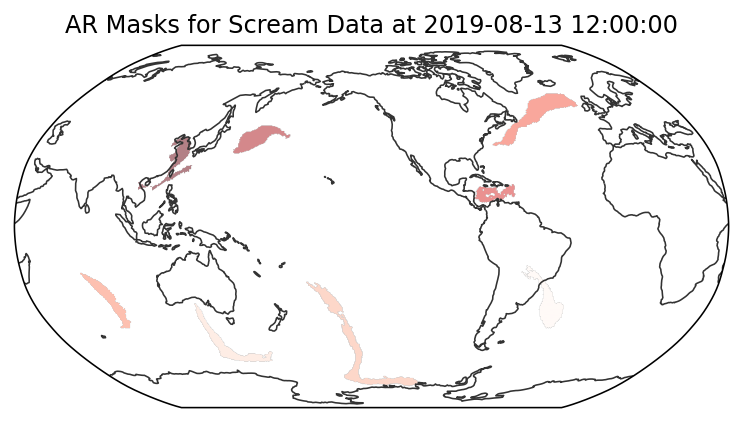

In [219]:
# Get file location
root_dir = '/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/'
in_mask_dir = f'{root_dir}scream2D_ne120_hp8_fast.ar_counts.for_Lexie.nc'
print(in_mask_dir)

# Open file
ds_scream_ARtrack_counts = xr.open_dataset(in_mask_dir)

for var in ds_scream_ARtrack_counts.data_vars:
    print(f"{var}: {ds_scream_ARtrack_counts[var].dims}, shape={ds_scream_ARtrack_counts[var].shape}")

# Plot Sample
temp = ds_scream_ARtrack_counts['AR_count_index'].isel(time=0).squeeze()
egh.healpix_show(temp.where(temp>0), cmap='Reds_r', dpi=144, alpha=0.5)
plt.title(f"AR Masks for Scream Data at {ds_scream_ARtrack_counts.time.isel(time=0).item()}")

### 1.2) SCREAM Data

In [189]:
str(ds_scream.time.isel(time=0).values)[0:13]

'2019-09-01T00'

Scream data you can load:
scream2D_ne120_inst_ivt_hp8.201912.nc
scream2D_ne120_inst_ivt_hp8.202005.nc
scream2D_ne120_inst_ivt_hp8.201908.nc
scream2D_ne120_inst_ivt_hp8.201909.nc
scream2D_ne120_inst_ivt_hp8.nc
scream2D_ne120_inst_ivt_hp8.202003.nc
scream2D_ne120_inst_ivt_hp8.202007.nc
scream2D_ne120_inst_ivt_hp8.201910.nc
scream2D_ne120_inst_ivt_hp8_test.nc
scream2D_ne120_inst_ivt_hp8.201911.nc
scream2D_ne120_inst_ivt_hp8.202008.nc
scream2D_ne120_inst_ivt_hp8.202004.nc
scream2D_ne120_inst_ivt_hp8.202006.nc
scream2D_ne120_inst_ivt_hp8.202002.nc
scream2D_ne120_inst_ivt_hp8.202001.nc
uivt: ('time', 'cell'), shape=(241, 786432)
vivt: ('time', 'cell'), shape=(241, 786432)
pr: ('time', 'cell'), shape=(241, 786432)
prs: ('time', 'cell'), shape=(241, 786432)
psl: ('time', 'cell'), shape=(241, 786432)
sfcWind: ('time', 'cell'), shape=(241, 786432)
zg300: ('time', 'cell'), shape=(241, 786432)
zg500: ('time', 'cell'), shape=(241, 786432)
ELEV: ('cell',), shape=(786432,)


<Figure size 640x480 with 0 Axes>

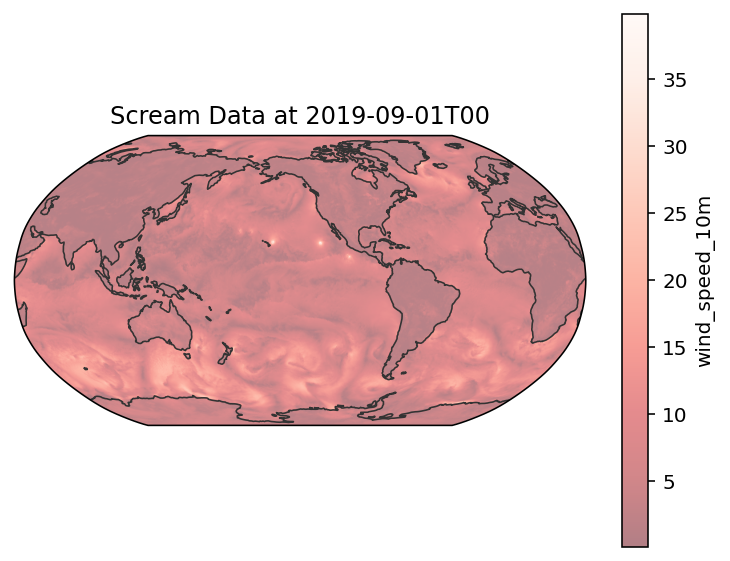

In [190]:
# List contents of the directory
# directory_path = '/pscratch/sd/w/wcmca1/scream-cess-healpix/data4TE'
# directory_path = '/pscratch/sd/c/chenzm/Work/OtherWorks/2025/Hackathon/Data'
directory_path = '/pscratch/sd/l/lexberg/Scream2D_data'
contents = os.listdir(directory_path)
in_mask_dir = f'{directory_path}/scream2D_ne120_inst_ivt_hp8.201909.nc'
print('Scream data you can load:')
for content in contents:
    print(content)

# Load in dataset
ds_scream = xr.open_dataset(in_mask_dir)
for var in ds_scream.data_vars:
    print(f"{var}: {ds_scream[var].dims}, shape={ds_scream[var].shape}")

# Example Plot
temp = ds_scream['sfcWind'].isel(time=0).squeeze()
cax = egh.healpix_show(temp.where(temp>0), cmap='Reds_r', dpi=144, alpha=0.5)
cb = fig.colorbar(cax)
plt.title(f"Scream Data at {str(ds_scream.time.isel(time=0).values)[0:13]}")
cb.set_label(ds_scream['sfcWind'].attrs['long_name']) 

### 1.3) HRRR Data
This needs to be reprocessed, but for some reason can only load in v3, not v4 or v5

wind_speed: ('time', 'cell'), shape=(75, 786432)


<Figure size 640x480 with 0 Axes>

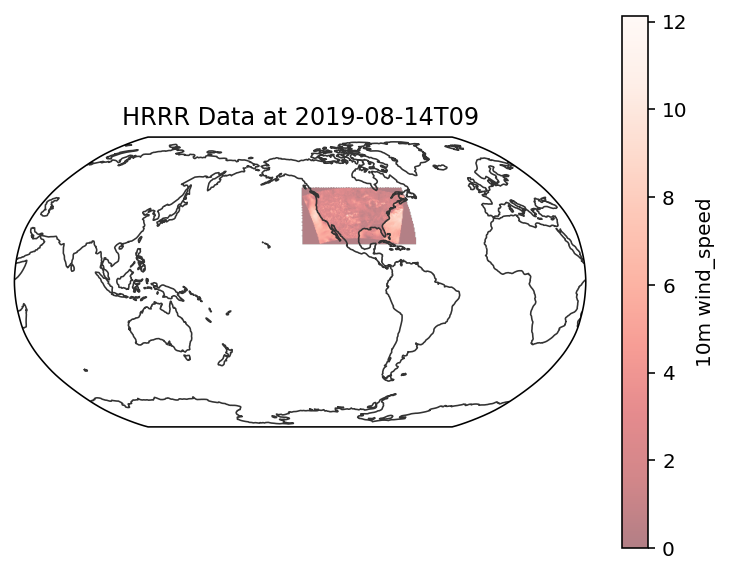

In [195]:
# Grab zarr hrrr data
out_dir = '/pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/'
filename = '_all_hp8_v3.zarr'
ds_hrrr = xr.open_zarr(os.path.join(out_dir, filename))

for var in ds_hrrr.data_vars:
    print(f"{var}: {ds_hrrr[var].dims}, shape={ds_hrrr[var].shape}")

# Example Plot
temp = ds_hrrr['wind_speed'].isel(time=0).squeeze()
cax = egh.healpix_show(temp, cmap='Reds_r', dpi=144, alpha=0.5)
cb = fig.colorbar(cax)
plt.title(f"HRRR Data at {str(ds_hrrr.time.isel(time=0).values)[0:13]}")
cb.set_label('10m ' + temp.name) 

In [98]:
# # This loads in the latest version of processing

# # Grab zarr hrrr data
# folder_path = '/pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/'
# print(f'folder where data stored: {folder_path}')
# pattern = re.compile(r'v(\d+)')  # Match v followed by a number anywhere in the filename

# matched_files = []
# for filename in os.listdir(folder_path):
#     match = pattern.search(filename)  # Use search instead of match
#     if match:
#         version_num = int(match.group(1))
#         matched_files.append((version_num, filename))

# # Find and collect files with the highest version number
# if matched_files:
#     max_version = max(v for v, _ in matched_files)
#     latest_files = [f for v, f in matched_files if v == max_version]
#     print("Files with the highest version (v{}):".format(max_version))
#     for f in latest_files:
#         print(f)
# else:
#     print("No matching files found.")

# pattern = re.compile(r'hp(\d+)')

# # Extract hp number and track filename
# hp_files = []
# for filename in latest_files:
#     match = pattern.search(filename)
#     if match:
#         hp_num = int(match.group(1))
#         hp_files.append((hp_num, filename))

# # Get file with the highest hp number
# if hp_files:
#     max_hp_file = max(hp_files, key=lambda x: x[0])[1]
#     print("File with the highest hp number:", max_hp_file)
# else:
#     print("No hp patterns found.")

# full_path = os.path.join(folder_path, max_hp_file)

# if os.path.isdir(full_path):
#     print("File exists:", full_path)
# else:
#     print("File does not exist:", full_path)

# ds_hrrr = xr.open_zarr(full_path)

### 1.4) AR Tracks Data for HRRR/ERA5 data


folder where data stored: /pscratch/sd/l/lexberg/hackathon2025/ARtracks_ERA5_hpZARR_data/
Files with the highest version (v2):
_all_hp5_v2.zarr
_all_hp7_v2.zarr
_all_hp1_v2.zarr
_all_hp4_v2.zarr
_all_hp6_v2.zarr
_all_hp0_v2.zarr
_all_hp3_v2.zarr
_all_hp2_v2.zarr
File with the highest hp number: _all_hp7_v2.zarr
File exists: /pscratch/sd/l/lexberg/hackathon2025/ARtracks_ERA5_hpZARR_data/_all_hp7_v2.zarr


Text(0.5, 1.0, 'AR Masks for ERA5/HRRR Data at 2019-08-01T00')

<Figure size 640x480 with 0 Axes>

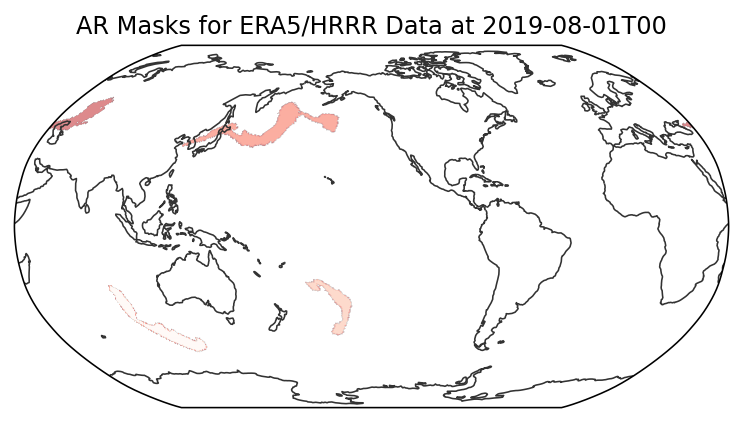

In [201]:
# This loads in the latest version

# Load in latest version
folder_path = '/pscratch/sd/l/lexberg/hackathon2025/ARtracks_ERA5_hpZARR_data/'  # Replace with your actual path
print(f'folder where data stored: {folder_path}')
pattern = re.compile(r'v(\d+)')  # Match v followed by a number anywhere in the filename

matched_files = []
for filename in os.listdir(folder_path):
    match = pattern.search(filename)  # Use search instead of match
    if match:
        version_num = int(match.group(1))
        matched_files.append((version_num, filename))

# Find and collect files with the highest version number
if matched_files:
    max_version = max(v for v, _ in matched_files)
    latest_files = [f for v, f in matched_files if v == max_version]
    print("Files with the highest version (v{}):".format(max_version))
    for f in latest_files:
        print(f)
else:
    print("No matching files found.")

pattern = re.compile(r'hp(\d+)')

# Extract hp number and track filename
hp_files = []
for filename in latest_files:
    match = pattern.search(filename)
    if match:
        hp_num = int(match.group(1))
        hp_files.append((hp_num, filename))

# Get file with the highest hp number
if hp_files:
    max_hp_file = max(hp_files, key=lambda x: x[0])[1]
    print("File with the highest hp number:", max_hp_file)
else:
    print("No hp patterns found.")

full_path = os.path.join(folder_path, max_hp_file)

if os.path.isdir(full_path):
    print("File exists:", full_path)
else:
    print("File does not exist:", full_path)

ds_hrrr_ARtrack = xr.open_zarr(full_path)

# Sample Plot
temp = ds_hrrr_ARtrack['AR_binary_tag'].isel(time=0).squeeze()
egh.healpix_show(temp.where(temp>0), cmap='Reds_r', dpi=144, alpha=0.5)
plt.title(f"AR Masks for ERA5/HRRR Data at {str(ds_hrrr_ARtrack.time.isel(time=0).values)[0:13]}")

# 2) Make Masks

Dataset naming convention:
- ds_hrrr['wind_speed']
- ds_hrrr_ARtrack['AR_binary_tag']
- ds_scream['sfcWind']
- ds_scream_ARtrack['AR_binary_tag']

### 2a) Mask Scream Data with AR tracks

In [ ]:
def mask_ARs(ds_scream, var, ds_scream_ARtrack):
    # Format SCREAM times
    scream_times = ds_scream['time'].values
    scream_str = np.array([np.datetime_as_string(t, unit='s') for t in scream_times])
    
    # Format ARtrack times
    artrack_times = ds_scream_ARtrack['time'].values
    try:
        artrack_str = np.array([t.strftime('%Y-%m-%dT%H:%M:%S') for t in artrack_times])
    except AttributeError:
        artrack_str = np.array([pd.Timestamp(t).strftime('%Y-%m-%dT%H:%M:%S') for t in artrack_times])
    
    # Find the intersection of the formatted times
    overlap_str = np.intersect1d(scream_str, artrack_str)
    
    print(f"Overlap count: {len(overlap_str)}")
    print(f"First overlap: {overlap_str[0] if len(overlap_str) > 0 else 'None'}")

    masked_results = []

    for t in overlap_str:
        ts = datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S')
        # print(ts)
        ds_data = ds_scream[var].sel(time=str(ts))
        ds_mask = ds_scream_ARtrack['AR_binary_tag'].sel(time=str(ts))
        
        masked = ds_data.where(ds_mask > 0.5).squeeze()
        masked_results.append(masked)
    
    masked_combined_scream = xr.concat(masked_results, dim='time')
    overlap_datetimes = [datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S') for t in overlap_str]
    masked_combined_scream['time'] = overlap_datetimes

    return overlap_datetimes, masked_combined_scream

Overlap count: 92
First overlap: 2019-09-01T00:00:00


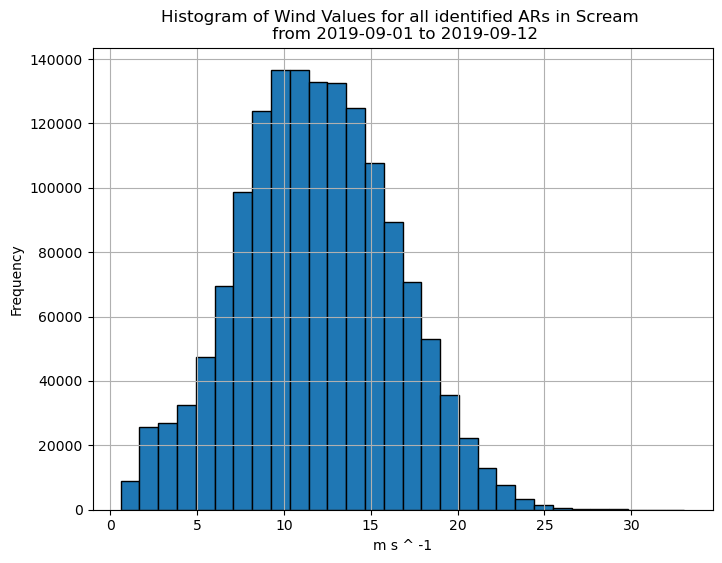

In [149]:
(overlap_datetimes_scream, masked_combined_scream) = mask_ARs(ds_scream, "sfcWind", ds_scream_ARtrack)

#Example Plot
# Plot all winds values for times identified
# Flatten all values into one array and remove NaNs
all_data = masked_combined_scream.values.flatten()
all_data = all_data[~np.isnan(all_data)]

t1 = masked_combined_scream.time[0].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')
t2 = masked_combined_scream.time[-1].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')

# Check if there's any data to plot
if all_data.size > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(all_data, bins=30, edgecolor='black')
    plt.title(f"Histogram of Wind Values for all identified ARs in Scream \n from {t1} to {t2}")
    plt.xlabel("m s ^ -1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for histogram.")

### 2b) Mask HRRR Data with AR tracks

In [205]:
(overlap_datetimes_hrrr, masked_combined_hrrr) = mask_ARs(ds_hrrr, "wind_speed", ds_hrrr_ARtrack)

#Example Plot
# Plot all winds values for times identified
# Flatten all values into one array and remove NaNs
all_data = masked_combined_hrrr.values.flatten()
all_data = all_data[~np.isnan(all_data)]

t1 = masked_combined_hrrr.time[0].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')
t2 = masked_combined_hrrr.time[-1].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')

# Check if there's any data to plot
if all_data.size > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(all_data, bins=30, edgecolor='black')
    plt.title(f"Histogram of Wind Values for all identified ARs in HRRR \n from {t1} to {t2}")
    plt.xlabel("m s ^ -1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for histogram.")

Overlap count: 37
First overlap: 2019-08-14T12:00:00
No valid data available for histogram.


Overlap count: 75
First overlap: 2019-08-14T09:00:00


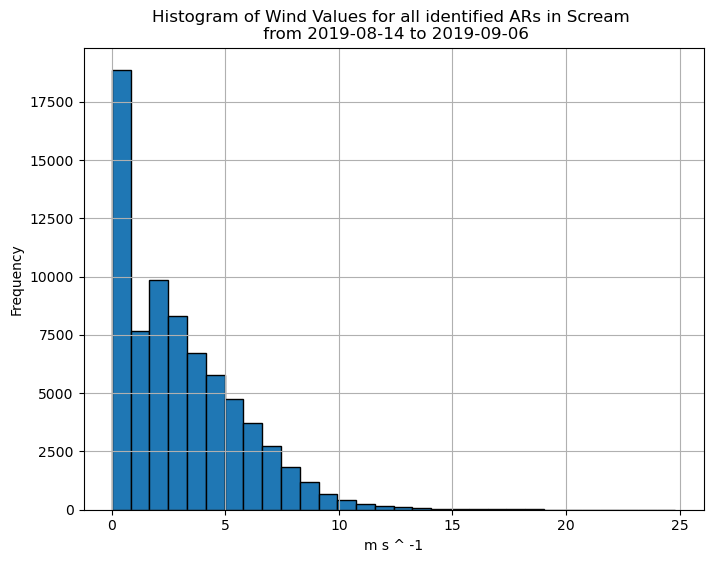

In [150]:
# Currently no overlap for processed HRRR data and ERA5 tracks, so testing with scream tracks
(overlap_datetimes_hrrr, masked_combined_hrrr) = mask_ARs(ds_hrrr, "wind_speed", ds_scream_ARtrack)

#Example Plot
# Plot all winds values for times identified
# Flatten all values into one array and remove NaNs
all_data = masked_combined_hrrr.values.flatten()
all_data = all_data[~np.isnan(all_data)]

t1 = masked_combined_hrrr.time[0].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')
t2 = masked_combined_hrrr.time[-1].values.astype('M8[ms]').astype(datetime.datetime).strftime('%Y-%m-%d')

# Check if there's any data to plot
if all_data.size > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(all_data, bins=30, edgecolor='black')
    plt.title(f"Histogram of Wind Values for all identified ARs in HRRR \n from {t1} to {t2} \n *using the scream mask")
    plt.xlabel("m s ^ -1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for histogram.")

### 2c) Mask CONUS versus Global

### 2d) Mask Land vs Water
https://easy.gems.dkrz.de/Processing/healpix/Land_sea_mask.html

Their example doesn't work???

## 2) Plot Data Example

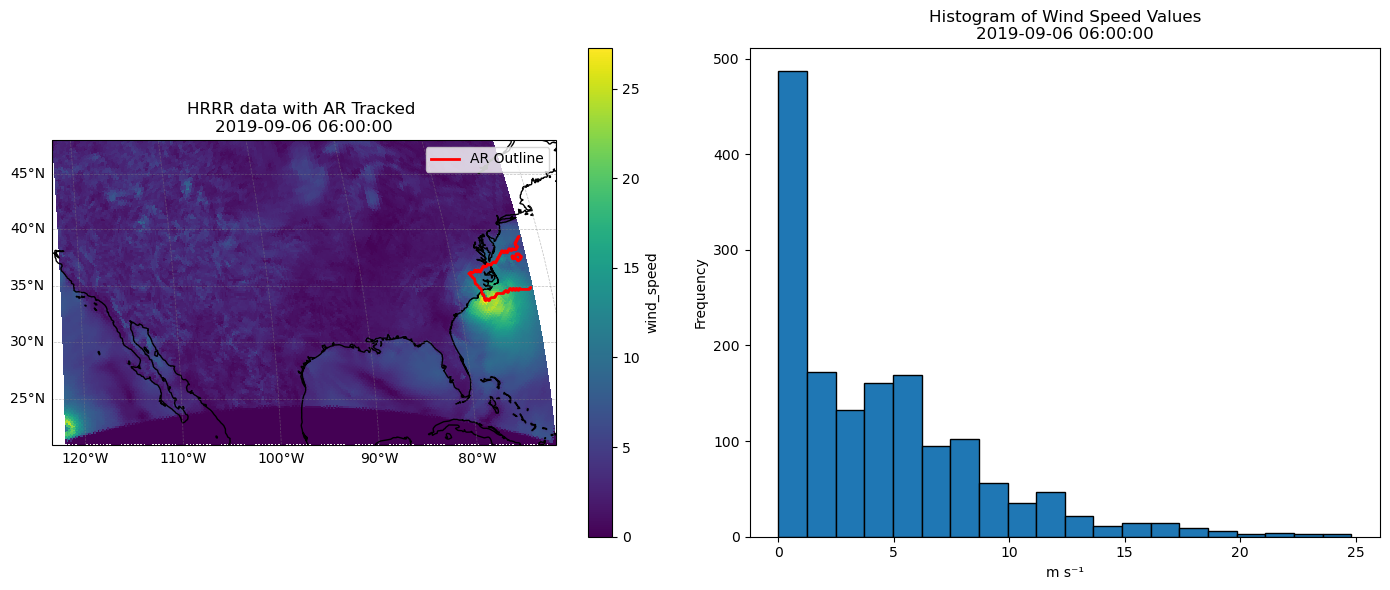

In [157]:
# Plot masked data on regional grid and get histogram
# EDIT TIME
t = cftime.DatetimeNoLeap(2019, 9, 6, 6, 0, 0, 0, has_year_zero=True)

# CONUS & ZOOM
zoom = get_zoom_level(ds_hrrr)
lon_min = -122
lon_max = -72
lat_min = 21
lat_max = 48
idx = get_nn_lon_lat_index(2**zoom, np.linspace(lon_min, lon_max, 300), np.linspace(lat_min, lat_max, 300))

# get  data
ts = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
ds_data = ds_hrrr['wind_speed'].sel(time = str(ts)).isel(cell=idx)
mask = ds_scream_ARtrack['AR_binary_tag'].sel(time= str(ts))
#ds_mask = mask.where(mask>0.5).isel(cell=idx)
ds_mask = mask.isel(cell=idx)
# Squeeze out the singleton dimension if present
ds_mask_2d = ds_mask.squeeze()

# Create figure and GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# --- Subplot 1: Map with projection ---
ax_map = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=225))
ds_data.plot(ax=ax_map, transform=ccrs.PlateCarree(), cmap='viridis')

# Contour mask outline
contour = ax_map.contour(
    ds_mask_2d['lon'], ds_mask_2d['lat'], ds_mask_2d,
    levels=[0.5], colors='red', linewidths=2,
    transform=ccrs.PlateCarree()
)

# Coastlines and gridlines
ax_map.coastlines()
gl = ax_map.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Custom legend for AR outline
ar_legend = mlines.Line2D([], [], color='red', linewidth=2, label='AR Outline')
ax_map.legend(handles=[ar_legend])
ax_map.set_title(f"HRRR data with Scream AR Tracked (why they dont line up) \n{str(t)}")

# --- Subplot 2: Histogram ---
ax_hist = fig.add_subplot(gs[1])

# Select data for histogram
masked = masked_combined_hrrr.sel(time=str(ts))
data = masked.values
AR = data[~np.isnan(data)]

# Plot histogram
ax_hist.hist(AR, bins=20, edgecolor='black')
ax_hist.set_title(f"Histogram of Wind Speed Values\n{str(t)}")
ax_hist.set_xlabel("m s⁻¹")
ax_hist.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# 3) Track consectuive ARs and combine

In [237]:
# Format ARtrack times into datetime
artrack_times = ds_scream_ARtrack_counts['time'].values
try:
    artrack_str = np.array([t.strftime('%Y-%m-%dT%H:%M:%S') for t in artrack_times])
except AttributeError:
    artrack_str = np.array([pd.Timestamp(t).strftime('%Y-%m-%dT%H:%M:%S') for t in artrack_times])

temp = [datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S') for t in artrack_str]
ds_scream_ARtrack_counts['time'] = temp

# Combine into new dataset
ds = xr.Dataset({
    "wind": ds_scream["sfcWind"],
    "index": ds_scream_ARtrack_counts['AR_count_index']
})

unique_indices = np.unique(ds['index'].values)
print(f' unique AR indicies {unique_indices}')

<xarray.Dataset> Size: 755MB
Dimensions:         (time: 240, cell: 786432, crs: 0)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2019-08-13T12:00:00 ... 2019-09...
  * crs             (crs) float64 0B 
Dimensions without coordinates: cell
Data variables:
    AR_count_index  (time, cell) int32 755MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes: (12/24)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          3
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel
    NCO:                          netCDF Operators version 5.3.2 (Homepage = ...
    history_of_appended_files:    Wed May 14 10:08:23 2025: Appended file /gl...
    history:                      Wed May 14 10:08:24 2025: ncrename -d ncol,...

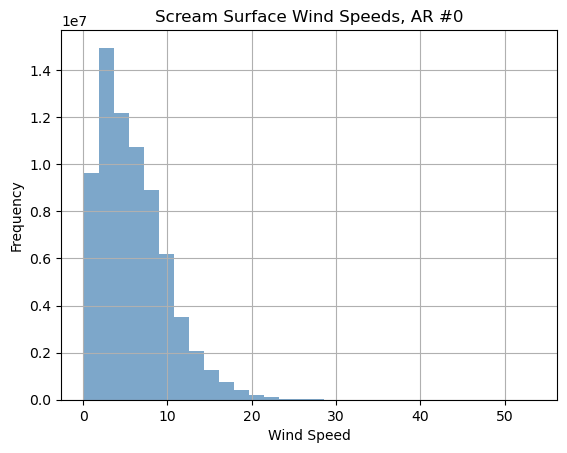

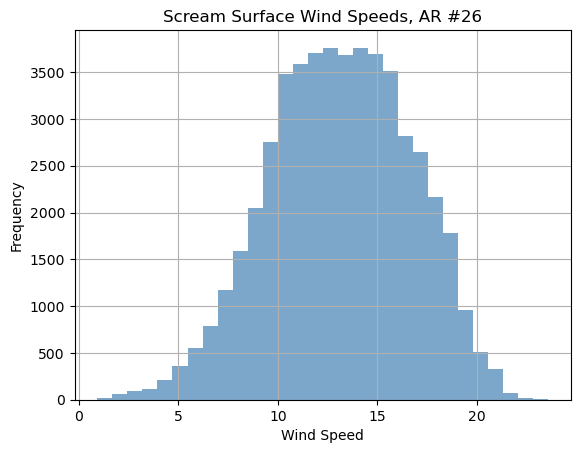

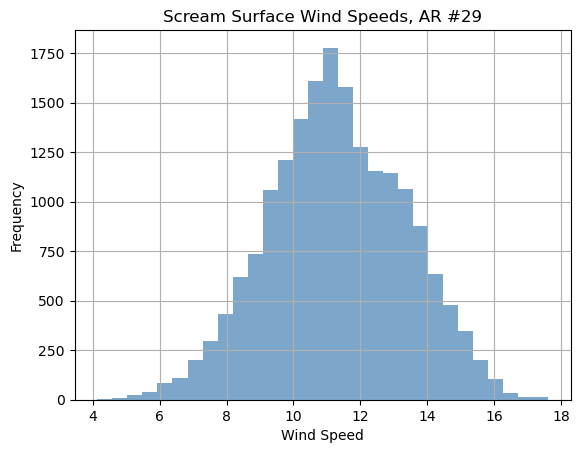

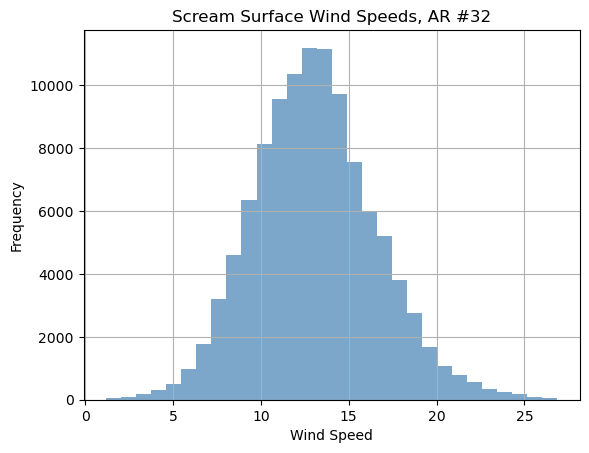

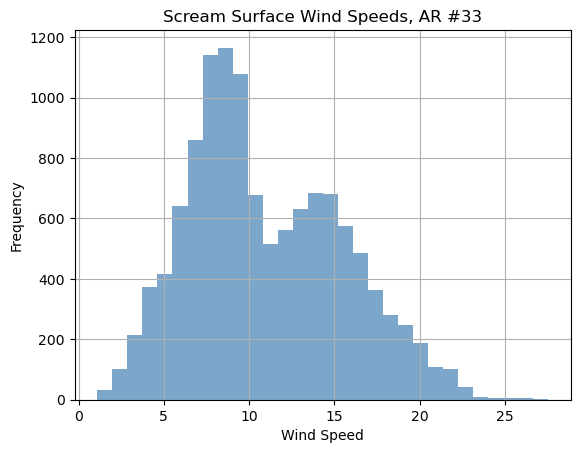

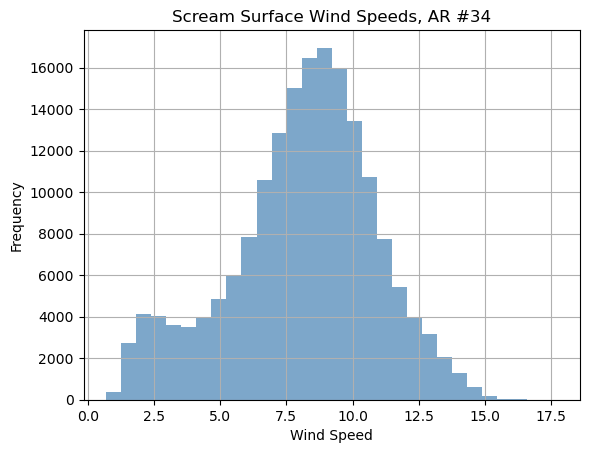

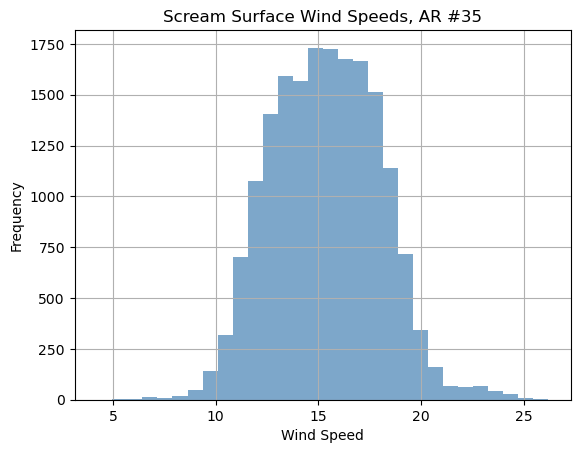

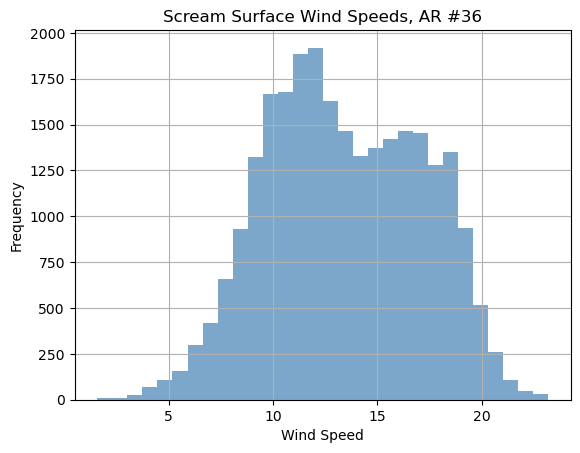

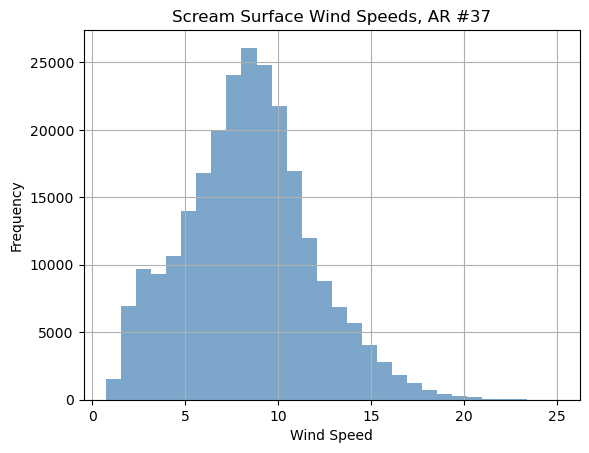

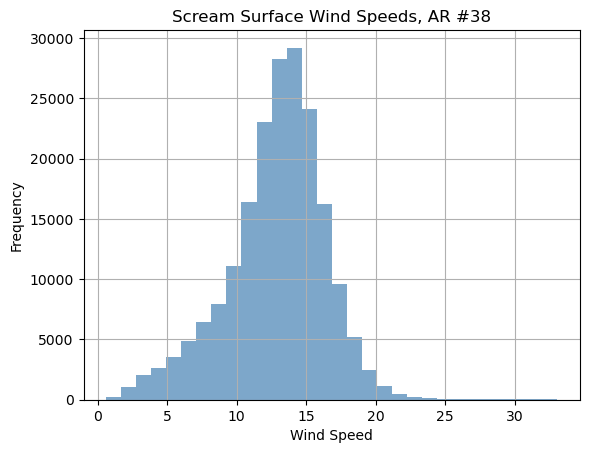

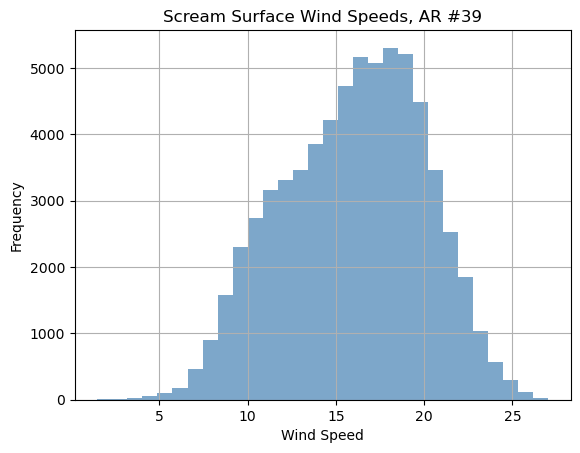

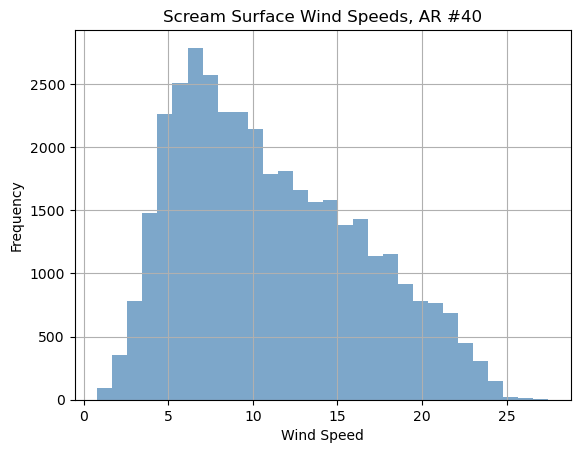

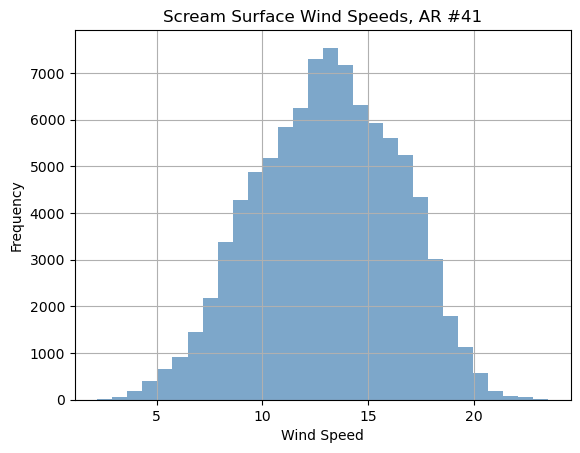

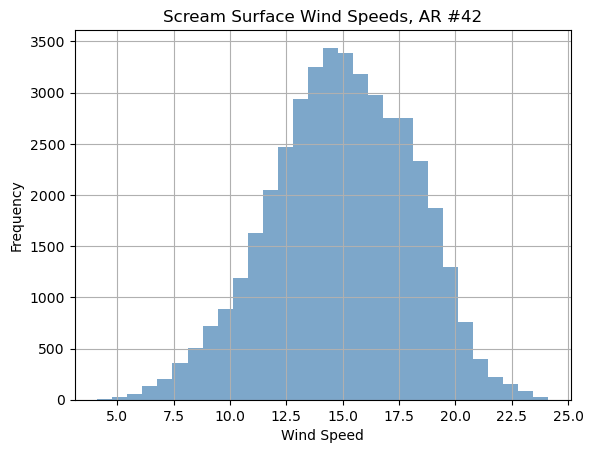

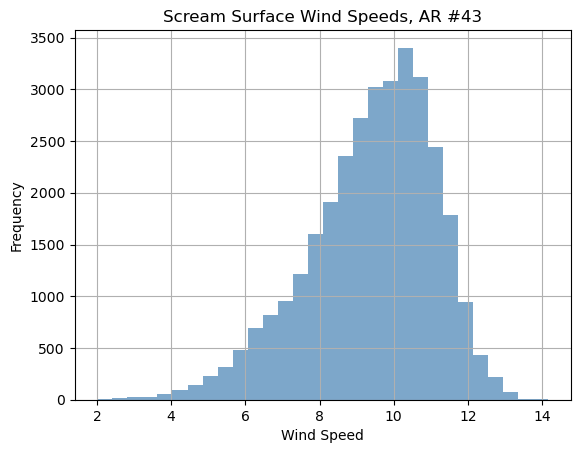

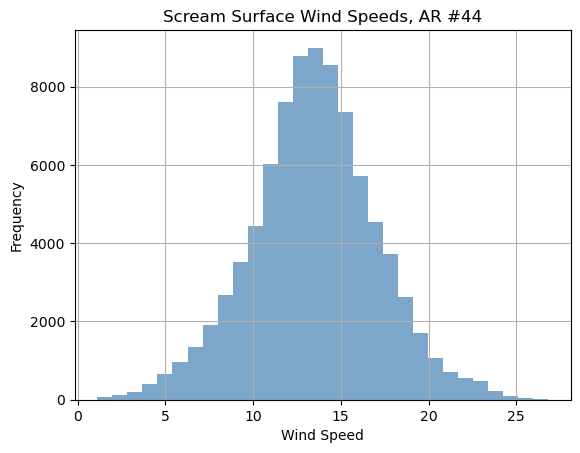

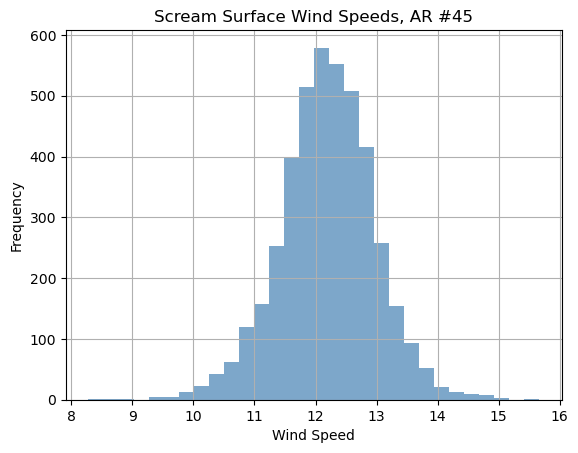

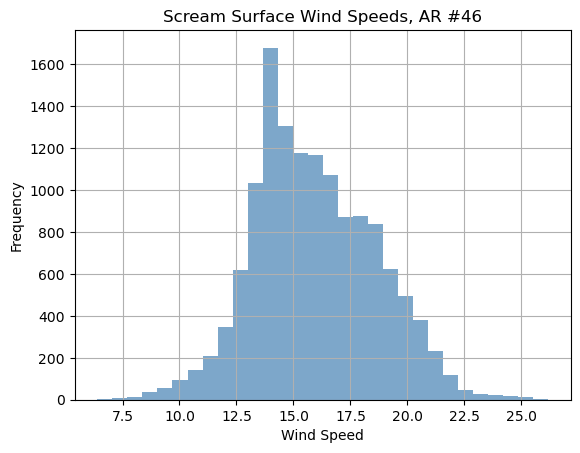

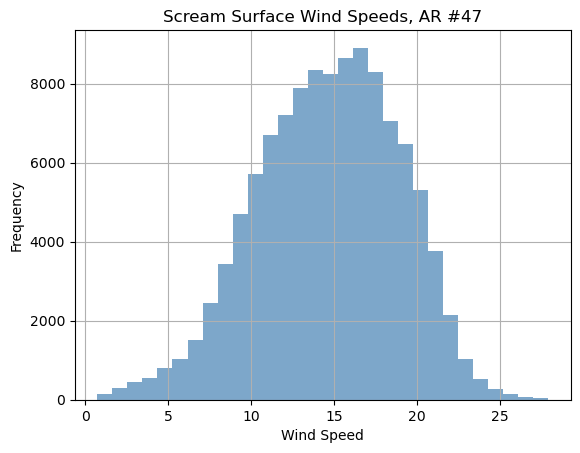

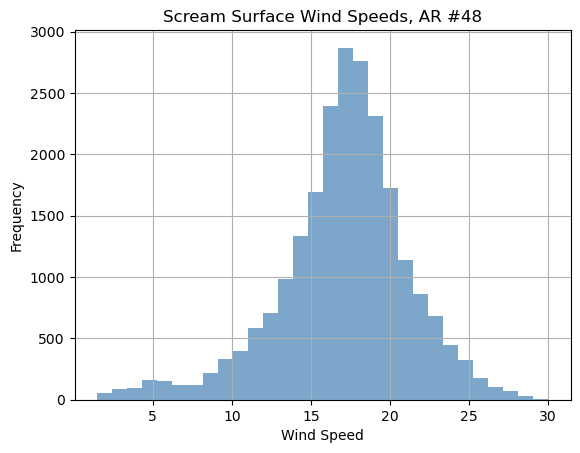

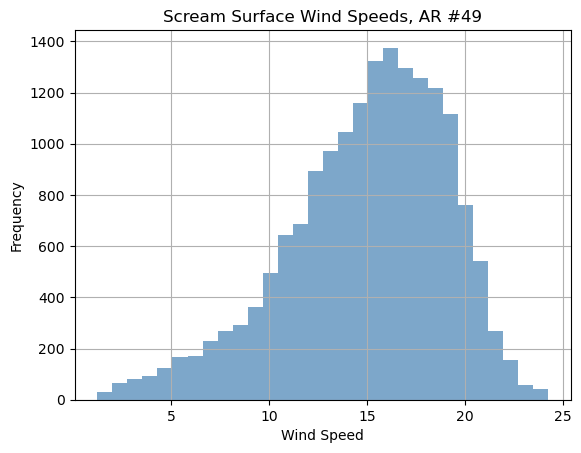

In [246]:
# Get unique index values, ignoring NaNs
unique_indices = np.unique(ds_scream_ARtrack_counts['AR_count_index'].values)

# Loop through each unique index value and plot histogram of wind values
for ind in unique_indices:
    # Create mask where index equals current idx
    mask = ds['index'] == ind

    # Apply mask to wind
    winds_at_index = ds_scream["sfcWind"].where(mask)

    # Flatten and drop NaNs
    values = winds_at_index.values.flatten()
    values = values[~np.isnan(values)]

    if values.size>0:
        # Plot histogram
        plt.figure()
        plt.hist(values, bins=30, alpha=0.7, color='steelblue')
        plt.title(f"Scream Surface Wind Speeds, AR #{int(ind)}")
        plt.xlabel("Wind Speed")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
    else:
        pass

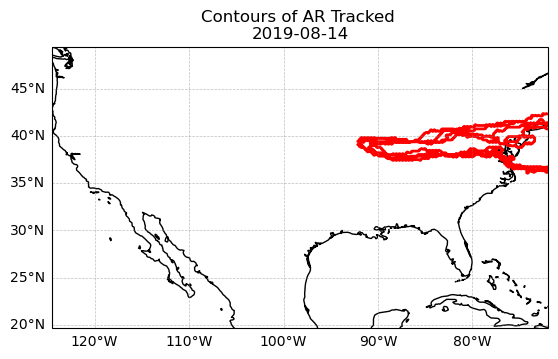

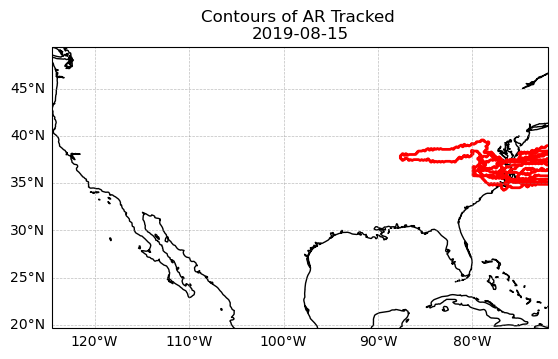

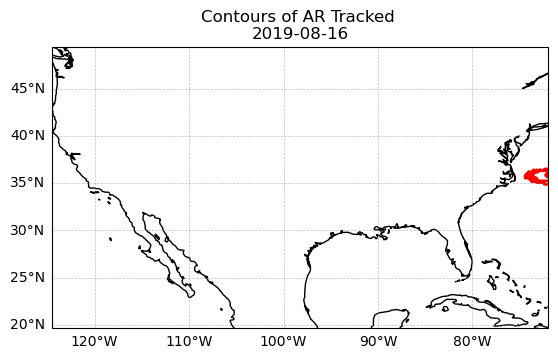

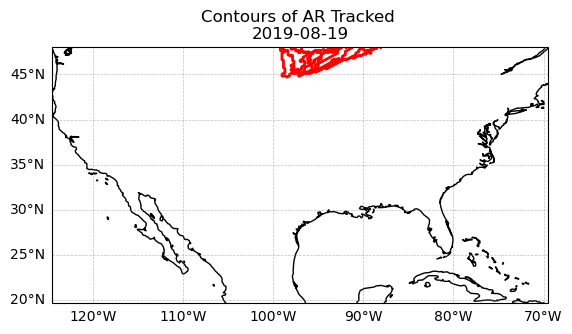

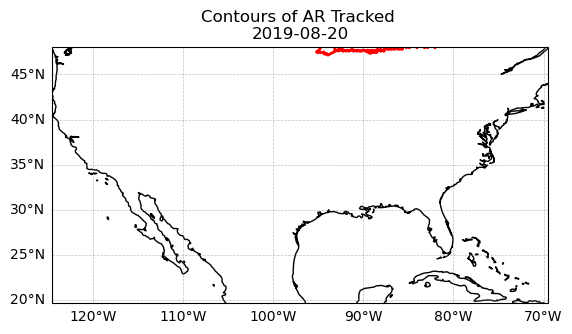

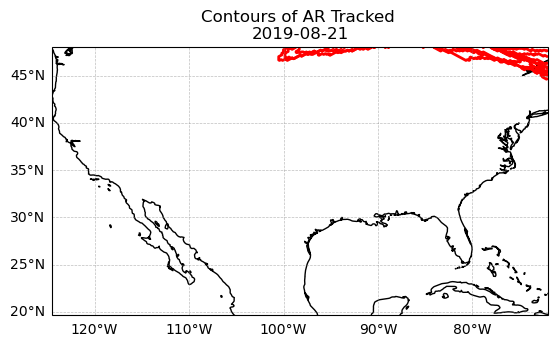

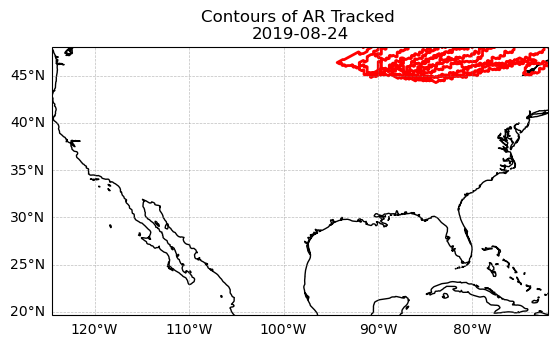

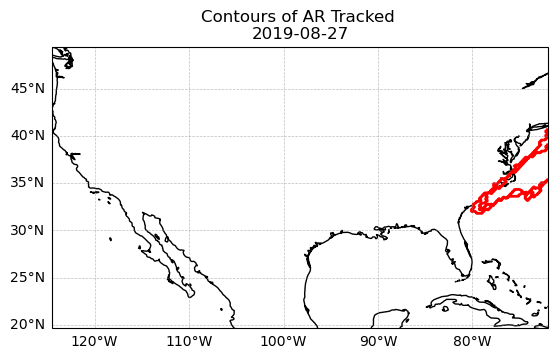

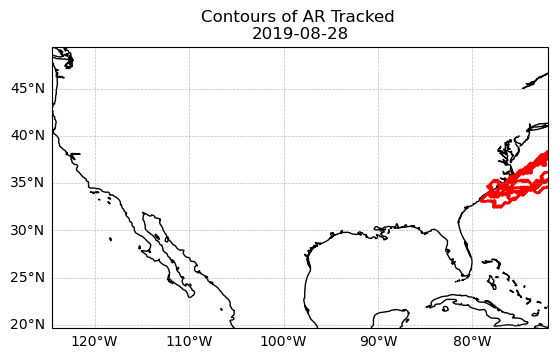

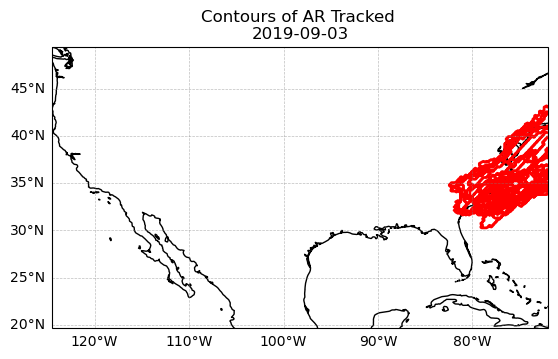

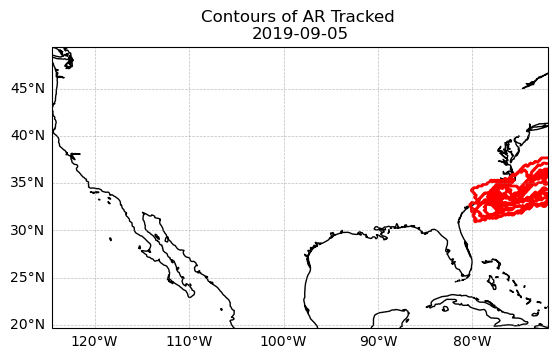

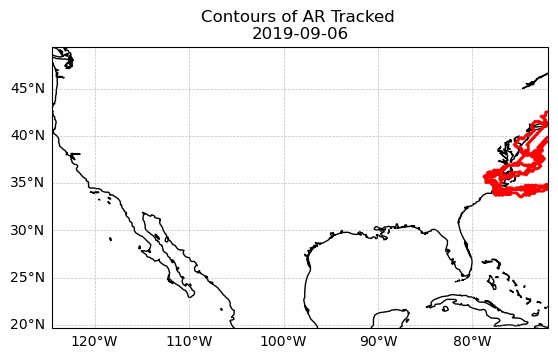

In [105]:
# Get mask area

# CONUS & ZOOM
zoom = get_zoom_level(dshp_ar)
lon_min = -122
lon_max = -72
lat_min = 21
lat_max = 48
idx = get_nn_lon_lat_index(2**zoom, np.linspace(lon_min, lon_max, 300), np.linspace(lat_min, lat_max, 300))



for group in groups:
    # Create figure 
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree(central_longitude=225)})
    for event in group:
        # Get time
        t = selected_times[event]
        # get  data
        ts = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
        mask = dshp_ar['AR_binary_tag'].sel(time= str(ts))
        #ds_mask = mask.where(mask>0.5).isel(cell=idx)
        ds_mask = mask.isel(cell=idx)
        # Squeeze out the singleton dimension if present
        ds_mask_2d = ds_mask.squeeze()

        # Contour mask outline
        contour = ax.contour(
            ds_mask_2d['lon'], ds_mask_2d['lat'], ds_mask_2d,
            levels=[0.5], colors='red', linewidths=2,
            transform=ccrs.PlateCarree()
        )

    # Coastlines and gridlines
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Custom legend for AR outline
    # ar_legend = mlines.Line2D([], [], color='red', linewidth=2, label='AR Outline')
    # ax_map.legend(handles=[ar_legend])
    ax.set_title(f"Contours of AR Tracked \n{str(t)[0:10]}")
    plt.show()